In [1]:
!pip install blitz-bayesian-pytorch


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [4]:
start = -7
end = 7
n = 300
batch_size = 16

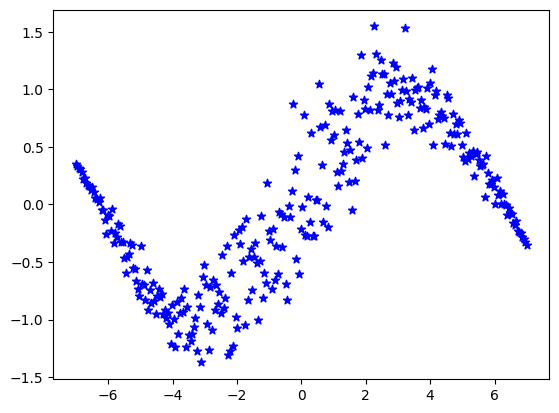

In [5]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

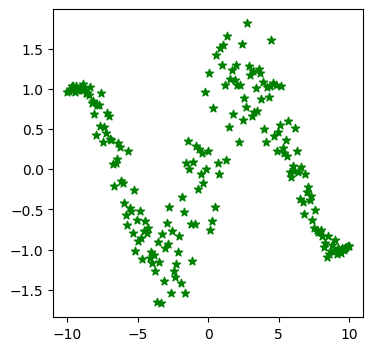

In [6]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

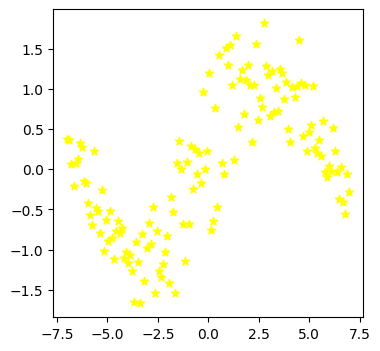

In [7]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


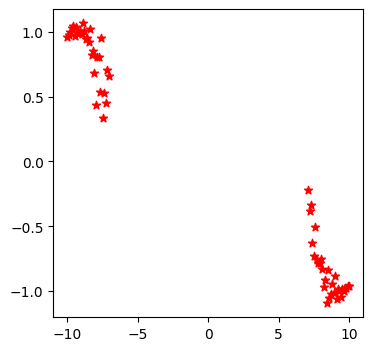

In [8]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [9]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 60

        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        var = torch.exp(self.var(h))
        return mu, var

model = SimpleNet()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)
Params: 3902


In [11]:
sns.set(rc={'figure.figsize':(4, 4)})
def make_plot_de(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]
    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)
    df = pd.concat(dfs).reset_index()
    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)
    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)
    plt.savefig("de.png", dpi=300, bbox_inches='tight')  # Add this line
    plt.show()

In [12]:
def make_plot_de_oodd(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test_oodd)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_oodd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.1)

    plt.show()

In [13]:
def make_plot_de_idd(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test_idd)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_idd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.1)

    plt.show()

In [14]:
# Construct ensemble
num_models = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]

In [15]:
def denn():
  # Construct ensemble
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_models = 5
  deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()
            criterionmse_train = nn.MSELoss()
            mse_train = criterionmse_train(mu, y)
            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
            criterionmse_test = nn.MSELoss()
            all_mse_test.append(criterionmse_test(mu,y).item())
  test_loss = sum(all_test_losses)/len(all_test_losses)
  test_mse=sum(all_mse_test)/len(all_mse_test)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  make_plot_de(deep_ensemble)
  return loss,test_loss,mse_train, test_mse


In [16]:
def denn_oodd():
  # Construct ensemble
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_models = 5
  deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()
            criterionmse_train = nn.MSELoss()
            mse_train = criterionmse_train(mu, y)
            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
            criterionmse_test = nn.MSELoss()
            all_mse_test.append(criterionmse_test(mu,y).item())
  test_loss = sum(all_test_losses)/len(all_test_losses)
  test_mse=sum(all_mse_test)/len(all_mse_test)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  make_plot_de_oodd(deep_ensemble)
  return loss,test_loss,mse_train, test_mse


In [17]:
def denn_idd():
  # Construct ensemble
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_models = 5
  deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()
            criterionmse_train = nn.MSELoss()
            mse_train = criterionmse_train(mu, y)
            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
            criterionmse_test = nn.MSELoss()
            all_mse_test.append(criterionmse_test(mu,y).item())
  test_loss = sum(all_test_losses)/len(all_test_losses)
  test_mse=sum(all_mse_test)/len(all_mse_test)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  make_plot_de_idd(deep_ensemble)
  return loss,test_loss,mse_train, test_mse


Epoch 149 | batch train loss: -0.8699768781661987 | test loss: 0.8622504646961506
Epoch 149 |batch train mse:0.11631321161985397| test mse:0.15907502432282156


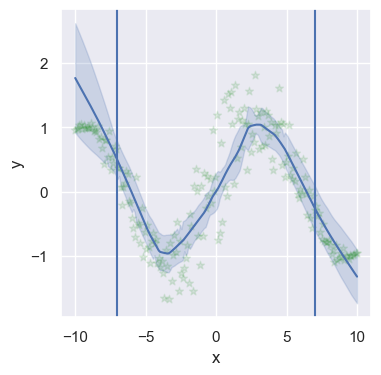

Epoch 149 | batch train loss: -0.9145416498184205 | test loss: 0.5225194862255683
Epoch 149 |batch train mse:0.052305668592453| test mse:0.15501590932791048


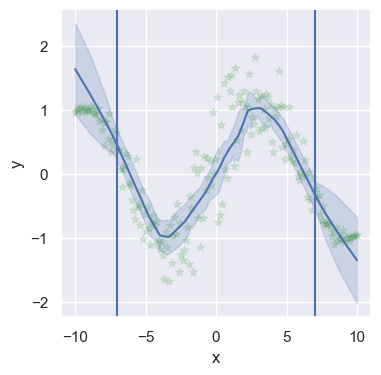

Epoch 149 | batch train loss: -0.8546214461326599 | test loss: 1.2439070123892564
Epoch 149 |batch train mse:0.06443194299936295| test mse:0.17429533830055824


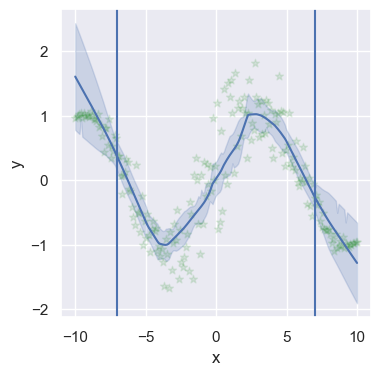

Epoch 149 | batch train loss: -0.9040935397148132 | test loss: 0.5213487207889557
Epoch 149 |batch train mse:0.08287101238965988| test mse:0.14098375634505197


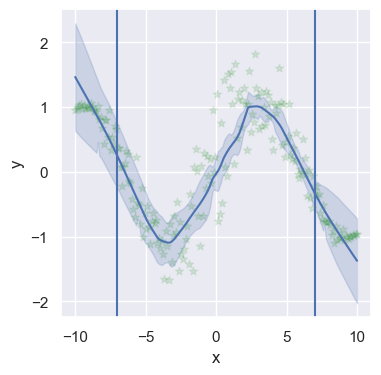

Epoch 149 | batch train loss: -0.9336870074272156 | test loss: 0.16541227847337725
Epoch 149 |batch train mse:0.0815577432513237| test mse:0.16276501205105048


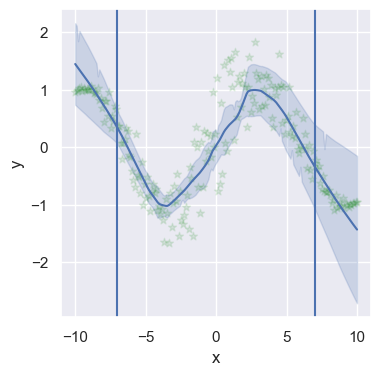

Epoch 149 | batch train loss: -1.0634960412979126 | test loss: 0.17731734961271284
Epoch 149 |batch train mse:0.05710415542125702| test mse:0.1421172911157975


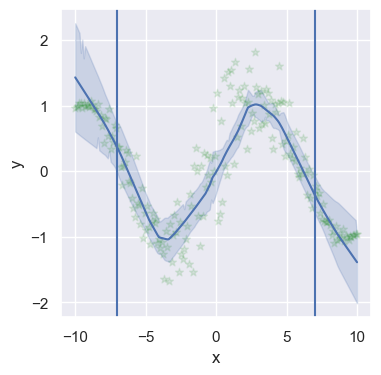

Epoch 149 | batch train loss: -1.3740942478179932 | test loss: 0.3768327006926903
Epoch 149 |batch train mse:0.02627742476761341| test mse:0.16362958057568625


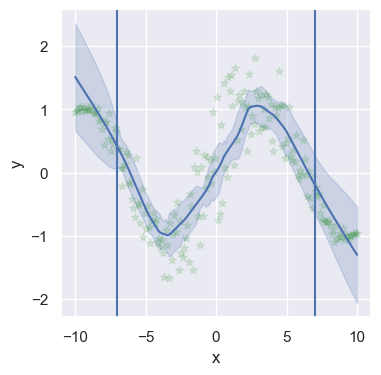

Epoch 149 | batch train loss: -1.436704969406128 | test loss: 0.6723920540167735
Epoch 149 |batch train mse:0.026344837620854378| test mse:0.15326581608790618


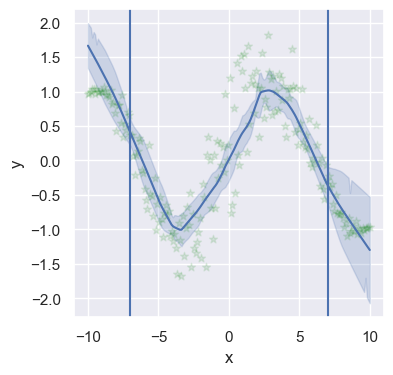

Epoch 149 | batch train loss: -1.0498902320861816 | test loss: 1.2849784770837198
Epoch 149 |batch train mse:0.0881587564945221| test mse:0.16052078398374411


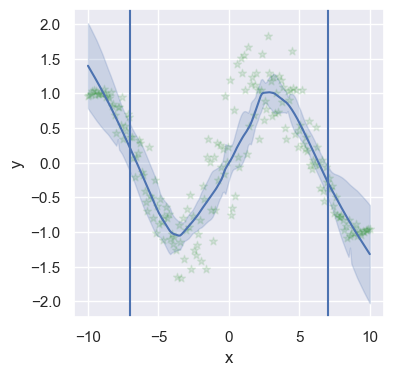

Epoch 149 | batch train loss: -1.0291159749031067 | test loss: 0.7572591880193124
Epoch 149 |batch train mse:0.05209428071975708| test mse:0.16157853374114403


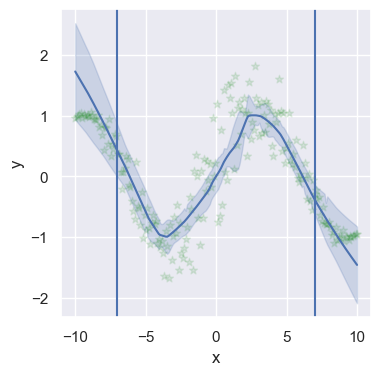

In [18]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = denn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)


Epoch 149 | batch train loss: -1.0200496435165405 | test loss: 2.9194027334451675
Epoch 149 |batch train mse:0.06702128052711487| test mse:0.10350853484123945


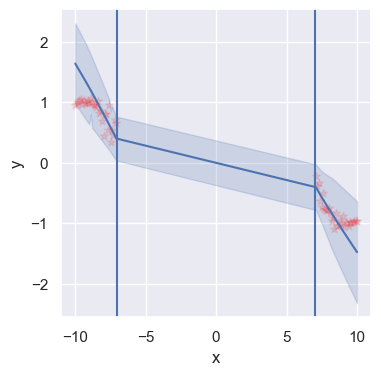

Epoch 149 | batch train loss: -1.5194859981536866 | test loss: -0.22222758531570433
Epoch 149 |batch train mse:0.042198870331048965| test mse:0.039228532928973436


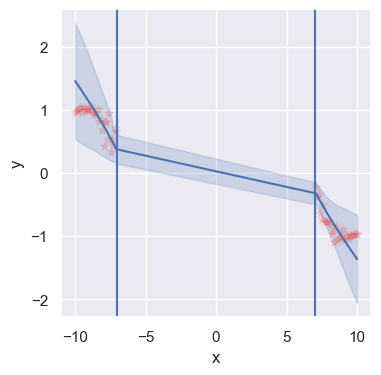

Epoch 149 | batch train loss: -1.041050124168396 | test loss: 0.7629300121217967
Epoch 149 |batch train mse:0.12461039423942566| test mse:0.04712004214525223


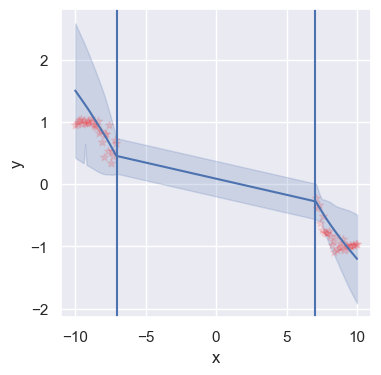

Epoch 149 | batch train loss: -1.2278887748718261 | test loss: 0.1628507412970066
Epoch 149 |batch train mse:0.06771653145551682| test mse:0.051481204107403755


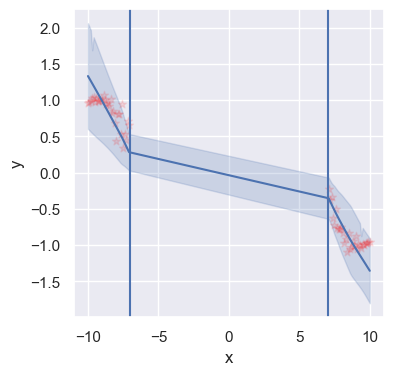

Epoch 149 | batch train loss: -1.3814863681793212 | test loss: 0.9360895261168479
Epoch 149 |batch train mse:0.027861028909683228| test mse:0.04391637537628412


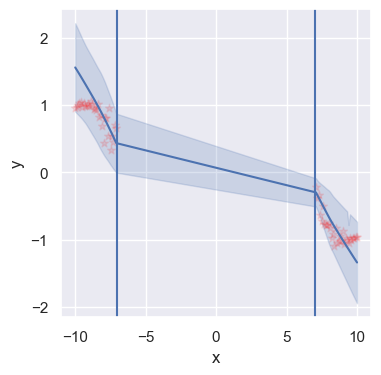

Epoch 149 | batch train loss: -1.0229530453681945 | test loss: 0.3014151453971863
Epoch 149 |batch train mse:0.05006098374724388| test mse:0.0694153355434537


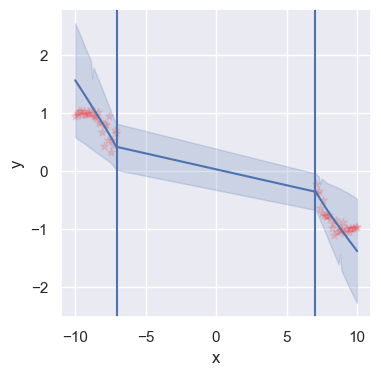

Epoch 149 | batch train loss: -0.9937345504760742 | test loss: 1.0653865054249763
Epoch 149 |batch train mse:0.10205286741256714| test mse:0.0845047440379858


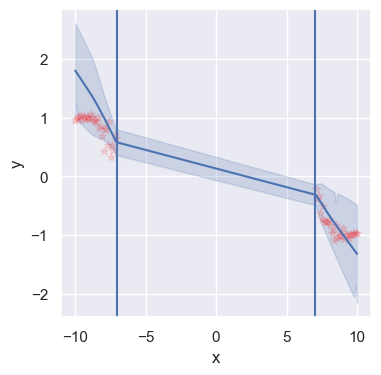

Epoch 149 | batch train loss: -1.2399222373962402 | test loss: 0.7324470818042755
Epoch 149 |batch train mse:0.07366599887609482| test mse:0.044337306171655655


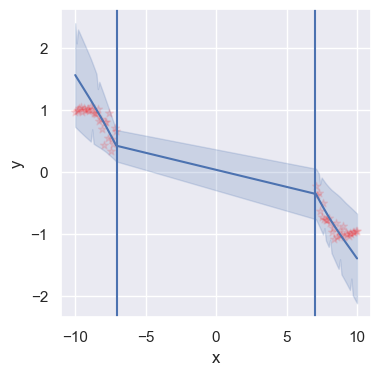

Epoch 149 | batch train loss: -1.1336121082305908 | test loss: 0.3011907625943422
Epoch 149 |batch train mse:0.029347768053412437| test mse:0.04299991577863693


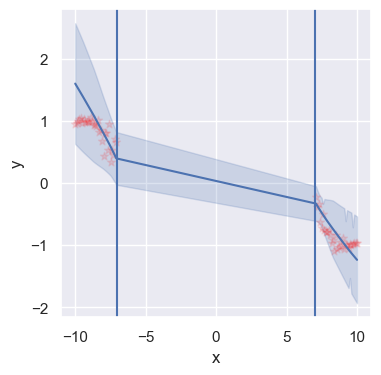

Epoch 149 | batch train loss: -1.3091325044631958 | test loss: 0.7869610378984362
Epoch 149 |batch train mse:0.058317407965660095| test mse:0.07061508111655712


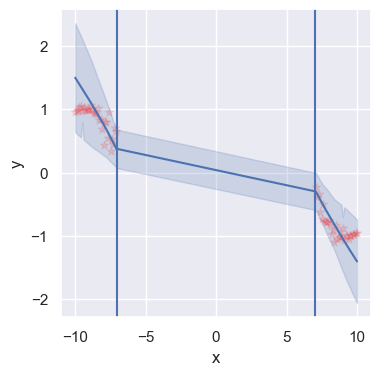

In [19]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = denn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)


Epoch 149 | batch train loss: -1.5302052974700928 | test loss: 0.7201539629035526
Epoch 149 |batch train mse:0.019383348524570465| test mse:0.19474315560526317


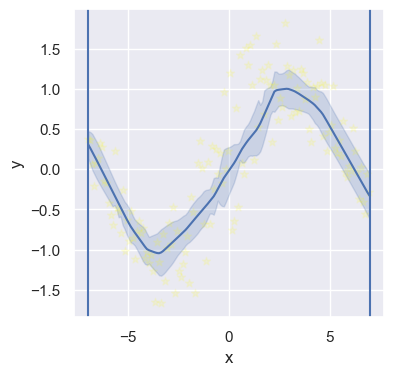

Epoch 149 | batch train loss: -1.0739444494247437 | test loss: 0.5002279529968897
Epoch 149 |batch train mse:0.10373568534851074| test mse:0.18716269814305836


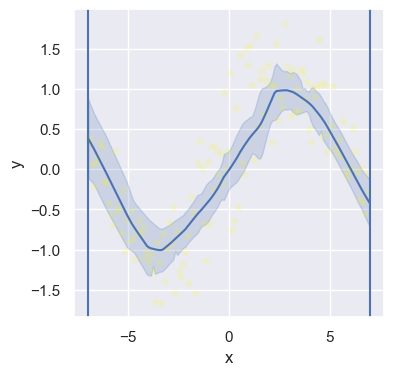

Epoch 149 | batch train loss: -1.1090432167053224 | test loss: 0.26741321103440385
Epoch 149 |batch train mse:0.03418475016951561| test mse:0.1975024069348971


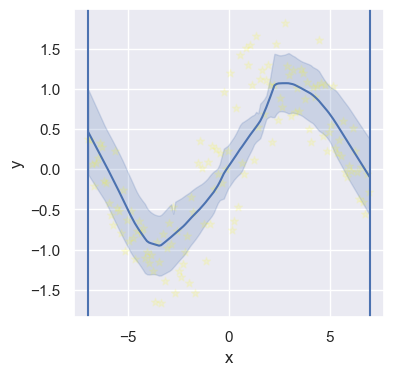

Epoch 149 | batch train loss: -1.2277052640914916 | test loss: 0.5795548859983684
Epoch 149 |batch train mse:0.07297848165035248| test mse:0.19310328778293398


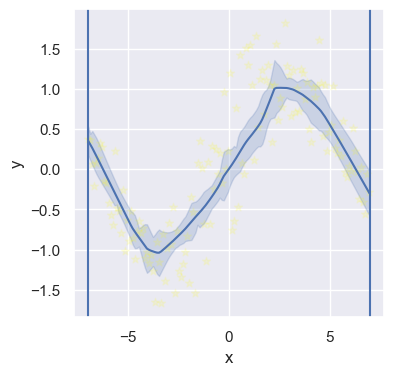

Epoch 149 | batch train loss: -1.100413727760315 | test loss: 0.2675589501029915
Epoch 149 |batch train mse:0.09977509826421738| test mse:0.19046744952599207


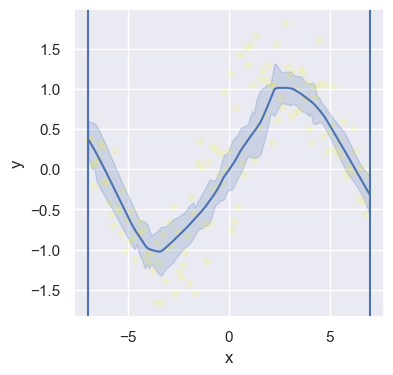

Epoch 149 | batch train loss: -1.6258100271224976 | test loss: 0.6446495234966279
Epoch 149 |batch train mse:0.015403696335852146| test mse:0.19480540189478132


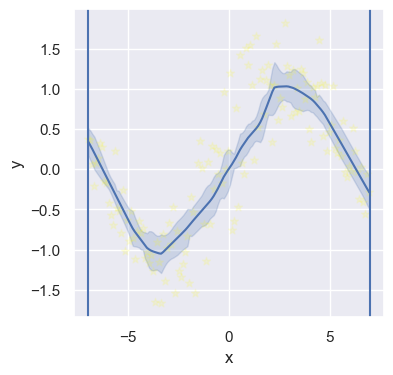

Epoch 149 | batch train loss: -0.9323150515556335 | test loss: 0.5892136540128073
Epoch 149 |batch train mse:0.07624369859695435| test mse:0.1918556069334348


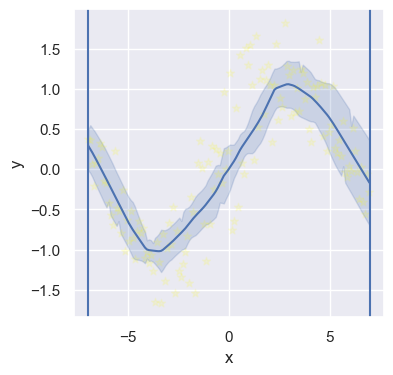

Epoch 149 | batch train loss: -0.8977233529090881 | test loss: 0.4815812029772335
Epoch 149 |batch train mse:0.10245970636606216| test mse:0.19362403659356964


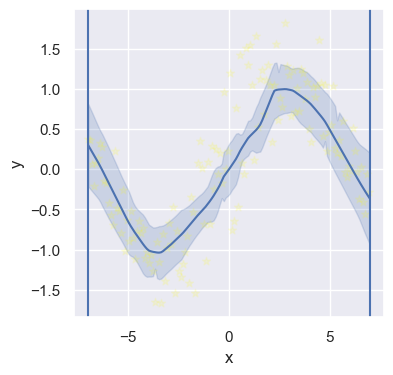

Epoch 149 | batch train loss: -0.8795793294906616 | test loss: 0.5239889778196811
Epoch 149 |batch train mse:0.09475903958082199| test mse:0.1913711486591233


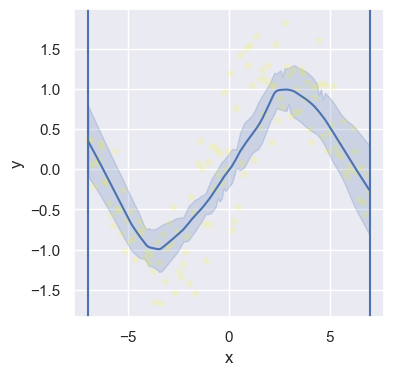

Epoch 149 | batch train loss: -0.9033768653869629 | test loss: 0.3247496091657215
Epoch 149 |batch train mse:0.14609748125076294| test mse:0.20228400495317247


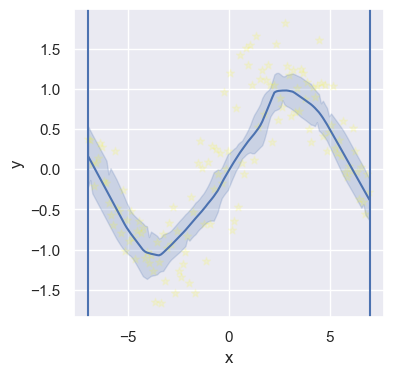

In [20]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = denn_idd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)


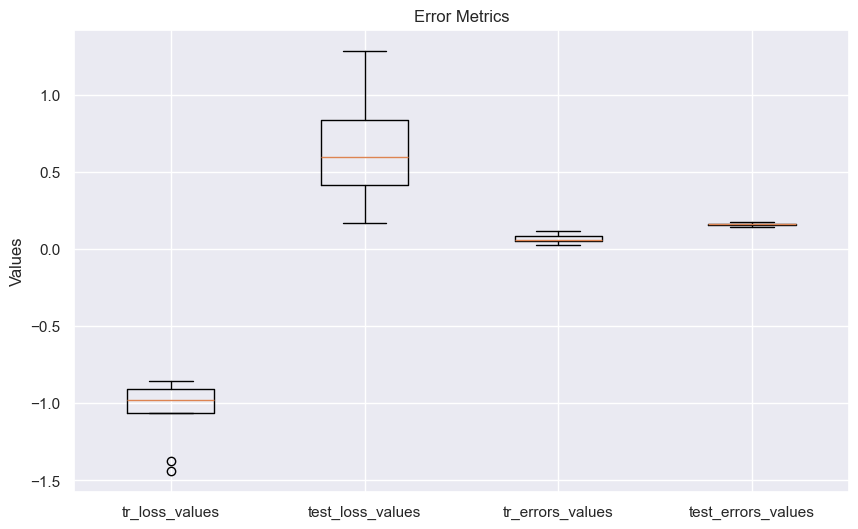

In [21]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= train_losses
test_loss_values=test_losses
tr_errors_values=  [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()



In [22]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.043022198677063
Standard Deviation of Gausiann Training Loss of 10 runs  0.19453963378633785
Mean of Gausiann Testing Loss of 10 runs  0.6584217731998517
Standard Deviation of Gausiann Testing Loss of 10 runs  0.3712070978072717
Mean of MSE Training of 10 runs  0.06474590338766575
Standard Deviation of MSE Training of 10 runs  0.02673254586682548
Mean of MSE Testing of 10 runs  0.15732470458516706
Standard Deviation of MSE Testing of 10 runs  0.009533213234072895


In [23]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_de.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -0.869977      0.862250                     0.116313   
2       -0.914542      0.522519                     0.052306   
3       -0.854621      1.243907                     0.064432   
4       -0.904094      0.521349                     0.082871   
5       -0.933687      0.165412                     0.081558   
6       -1.063496      0.177317                     0.057104   
7       -1.374094      0.376833                     0.026277   
8       -1.436705      0.672392                     0.026345   
9       -1.049890      1.284978                     0.088159   
10      -1.029116      0.757259                     0.052094   

    Mean Squared Testing Error  
1                     0.159075  
2                     0.155016  
3                     0.174295  
4                     0.140984  
5                     0.162765  
6                     0.142117  
7                     0.163630  
8                     0.153266 

In [24]:
print(test_errors_values)

[0.15907502432282156, 0.15501590932791048, 0.17429533830055824, 0.14098375634505197, 0.16276501205105048, 0.1421172911157975, 0.16362958057568625, 0.15326581608790618, 0.16052078398374411, 0.16157853374114403]
